In [1]:
## Imports (code & data)
import re
import pandas as pd
import yake_helper_funcs as yhf
from datetime import datetime, timedelta
from math import sqrt, floor
from sklearn.cluster import SpectralClustering
import numpy as np
import itertools
from matplotlib import pyplot as plt
import removing_polite_posts as rpp
from flashtext.keyword import KeywordProcessor
import string

forum_posts = pd.read_csv("../data/ForumMessages.csv")

# read in pre-tuned vectors
vectors = pd.read_csv("../data/fine-tuning-word2vec-2-0/kaggle_word2vec.model", 
                      delim_whitespace=True,
                      skiprows=[0], 
                      header=None
                     )

# set words as index rather than first column
vectors.index = vectors[0]
vectors.drop(0, axis=1, inplace=True)

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
## Utility functions

# get vectors for each word in post
# TODO: can we vectorize this?
def vectors_from_post(post):
    all_words = [] 

    for words in post:
        all_words.append(words) 
        
    return(vectors[vectors.index.isin(all_words)])


# create document embeddings from post
def doc_embed_from_post(post):
    test_vectors = vectors_from_post(post)

    return(test_vectors.mean())

# explore our posts by cluster
def get_keyword_set_by_cluster(number):
    cluster_index = list(clustering.labels_ == number)
    return(list(itertools.compress(keyword_sets, cluster_index)))

# get sample post info by #
def get_post_info_by_cluster(number, 
                             data,
                             cluster):
    return(data[cluster.labels_ == number])

# remove HTML stuff
# https://medium.com/@jorlugaqui/how-to-strip-html-tags-from-a-string-in-python-7cb81a2bbf44
def remove_html_tags(text):
    clean = re.compile('<.*?>')
    return(re.sub(clean, '', text))

# remove "good", "nice", "thanks", etc
def remove_thanks(text):
    text = text.lower()
    
    text = re.sub("nice", "", text)
    text = re.sub("thank.*\s", " ", text)
    text = re.sub("good","", text)
    text = re.sub("hi", "", text)
    text = re.sub("hello", "", text)
    
    return(text)

def polite_post_index(forum_posts):
    '''Pass in a list of fourm posts, get
    back the indexes of short, polite ones.'''
    
    polite_indexes = []
    
    # create  custom stop word list to identify polite forum posts
    stop_word_list = ["no problem", "thanks", "thx", "thank", "great",
                      "nice", "interesting", "awesome", "perfect", 
                      "amazing", "well done", "good job"]

    # create a KeywordProcess
    keyword_processor = KeywordProcessor()
    keyword_processor.add_keywords_from_list(stop_word_list)

    # test our keyword processor
    for i,post in enumerate(forum_posts):
        post = post.lower().translate(str.maketrans({a:None for a in string.punctuation}))
        
        if len(post) < 100:
            keywords_found = keyword_processor.extract_keywords(post.lower(), span_info=True)
            if keywords_found:
                polite_indexes.append(i)

    return(polite_indexes)

In [3]:
## Hyperprameters

# number of clusters currently based on the square root of the # of posts
days_of_posts = 1

# Preprocessing posts

In [4]:
# For sample posts, get forum title and topic title
# based on queries from https://www.kaggle.com/pavlofesenko/strategies-to-earn-discussion-medals
topics = pd.read_csv('../input/meta-kaggle//ForumTopics.csv').rename(columns={'Title': 'TopicTitle'})
forums = pd.read_csv('../input/meta-kaggle/Forums.csv').rename(columns={'Title': 'ForumTitle'})

df1 = pd.merge(forum_posts[['ForumTopicId', 'PostDate', 'Message']], topics[['Id', 'ForumId', 'TopicTitle']], left_on='ForumTopicId', right_on='Id')
df1 = df1.drop(['ForumTopicId', 'Id'], axis=1)

forum_posts = pd.merge(df1, forums[['Id', 'ForumTitle']], left_on='ForumId', right_on='Id')
forum_posts = forum_posts.drop(['ForumId', 'Id'], axis=1)
forum_posts.head()

,PostDate,Message,TopicTitle,ForumTitle
0,04/28/2010 23:13:08,<div>In response to a comment on the No Free H...,A few techniques you might try:,Predict HIV Progression
1,04/28/2010 23:13:08,Use a mixture of different models (linear regr...,A few techniques you might try:,Predict HIV Progression
2,04/28/2010 23:13:08,My first thoughts on this problem are that it ...,A few techniques you might try:,Predict HIV Progression
3,04/28/2010 23:13:08,The theory of deep belief networks is probably...,A few techniques you might try:,Predict HIV Progression
4,04/28/2010 23:13:08,"Going by Hinton's last two google techtalks, r...",A few techniques you might try:,Predict HIV Progression


In [5]:
# parse dates
forum_posts['Date'] = pd.to_datetime(forum_posts.PostDate, format="%m/%d/%Y %H:%M:%S")

# posts from the last X days
start_time = datetime.now() + timedelta(days=-days_of_posts)  

# forum posts from last week (remember to convert to str)
sample_post_info = forum_posts.loc[forum_posts.Date > start_time]
sample_posts = sample_post_info.Message.astype(str)

# reindex from 0
sample_posts.reset_index(drop=True)
sample_post_info.reset_index(drop=True)

# remove html tags
sample_post_info.Message = sample_post_info.Message\
    .astype(str)\
    .apply(remove_html_tags)
sample_posts = sample_posts.apply(remove_html_tags)

# remove polite posts (make sure you remove HTML tags first)
polite_posts = sample_posts.index[polite_post_index(sample_posts)]
# posts aren't being dropped 
sample_posts = sample_posts.drop(polite_posts)
sample_post_info = sample_post_info.drop(polite_posts)

# number of posts
num_of_posts = sample_posts.shape[0]

# Number of clusters is square root of the # of posts (rounded down)
number_clusters = floor(sqrt(num_of_posts))

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5209: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [6]:
# extact keywords & tokenize
#keywords = yhf.keywords_yake(sample_posts, )
keywords_tokenized = yhf.tokenizing_after_YAKE(sample_posts)
keyword_sets = [set(post) for post in keywords_tokenized]

# Get word vectors for keywords in post

In [7]:
# create empty array for document embeddings
doc_embeddings = np.zeros([num_of_posts, 300])

# get document embeddings for posts
for i in range(num_of_posts):
    embeddings = np.array(doc_embed_from_post(keyword_sets[i]))
    if np.isnan(embeddings).any():
        doc_embeddings[i,:] = np.zeros([1,300])
    else:
        doc_embeddings[i,:] = embeddings

# Clustering!

In [8]:
# the default k-means label assignment didn't work well
clustering = SpectralClustering(n_clusters=number_clusters, 
                                assign_labels="discretize",
                                n_neighbors=number_clusters).fit(doc_embeddings)

In [9]:
# look at distrobution of cluster labels
pd.Series(clustering.labels_).value_counts()

0     91
10    29
7     12
9     11
3     11
6      7
8      6
1      5
5      4
4      4
11     3
2      3
dtype: int64

In [10]:
for i in range(number_clusters):
    
    print(f"Cluster {i}:\n")
    print(get_post_info_by_cluster(i, 
                                   data = sample_post_info,
                                   cluster = clustering))
    print("\n")
    

Cluster 0:

                   PostDate  \
50816   08/23/2019 03:15:55   
51384   08/22/2019 22:39:19   
51387   08/23/2019 09:09:52   
51388   08/23/2019 08:01:09   
51412   08/23/2019 10:18:07   
...                     ...   
504202  08/23/2019 08:12:31   
504494  08/23/2019 02:09:56   
508758  08/22/2019 23:36:47   
508759  08/22/2019 23:57:06   
508760  08/23/2019 03:30:54   

                                                  Message  \
50816   The Stanford cs231n CNN videos on YouTube are ...   
51384   With endless sources of information that we ha...   
51387   Dear Beginners !!!\n\nIt's no surprise that so...   
51388   Hello everyone,\n\nCase studies and projects a...   
51412                         didn't know, appreciate it!   
...                                                   ...   
504202  Hi !\nCan someone tell me what the variable va...   
504494  I provide a new aspect to generate models. I c...   
508758  Lack of information on technology, lack of qua...   
50875

In [11]:
# for i in range(number_clusters):
    
#     print(f"Cluster {i}:\n")
#     print(get_keyword_set_by_cluster(i))
#     print("\n")

# Refining clustering

Steps:

1. Drop empty clusters
2. Identify large clusters (2 times more than expected)
3. Recluster those clusters (# clusters = sqrt # posts)



In [12]:
# count of posts/cluster
cluster_counts = pd.Series(clustering.labels_).value_counts()

# get clusters bigger than expected
max_cluster_size = number_clusters * 2
big_clusters = cluster_counts[cluster_counts > max_cluster_size]

In [13]:
# sub-cluster first (biggest) cluster
cluster_label = big_clusters.index[0]

sub_sample = sample_post_info[clustering.labels_ == cluster_label]
sub_cluster_embeddings = doc_embeddings[clustering.labels_ == cluster_label]

number_sub_clusters = floor(sqrt(sub_sample.shape[0]))

sub_cluster = SpectralClustering(n_clusters=number_sub_clusters, 
                                 assign_labels="discretize", 
                                 n_neighbors=number_sub_clusters).fit(sub_cluster_embeddings)

In [14]:
# see how it looks
for i in range(number_sub_clusters):

    print(f"Cluster {i}:\n")
    print(get_post_info_by_cluster(i, data = sub_sample, 
                                   cluster = sub_cluster))
    print("\n")

Cluster 0:

                   PostDate  \
247564  08/23/2019 08:24:20   
272637  08/23/2019 06:46:29   
272666  08/23/2019 05:18:50   
272672  08/23/2019 03:27:59   
334626  08/22/2019 19:57:16   
405478  08/22/2019 21:19:49   
405479  08/23/2019 03:27:34   
405481  08/23/2019 05:43:03   
508760  08/23/2019 03:30:54   

                                                  Message  \
247564  There are many ways to exploit this leak as yo...   
272637  I've also had an additional thought about this...   
272666  I have not used any of them for training yet. ...   
272672  That was a bit rough to read through. Can you ...   
334626  Data Scientist, *Data analyst* and a business ...   
405478  Either they have an economic hard time on the ...   
405479  I don't know how often houses are built but ba...   
405481  In my opinion, the data was collected a few ye...   
508760  Very interesting piece of work -  @dhafer  do ...   

                                               TopicTitle  \
24756

In [15]:
pd.Series(sub_cluster.labels_).value_counts()

1    37
4    18
5    10
0     9
8     6
3     5
6     3
2     3
dtype: int64

# Word clouds

In [16]:
from os import path
from wordcloud import WordCloud
import matplotlib.pyplot as plt

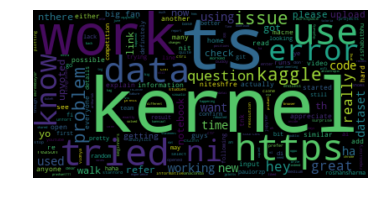

In [17]:
# TODO why do I see thank you?
posts_as_string = sample_post_info\
    .Message\
    .to_string(index=False)

# shouldn't have to do this b/c I removed polite posts earlier
posts_as_string = remove_thanks(posts_as_string)

# Generate a word cloud image
wordcloud = WordCloud().generate(posts_as_string)

# Display the generated image:
# the matplotlib way:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Going forward

Biggest problem: redundent clusters

Possible solutions: 

* Remove very short posts
* Don't include posts on kernels
* Build filter for removing short "thanks!" type posts
* Start w/ sentiment analys & put all very high sentiment posts in a single bin

# Visualization brain storming

Slides on text visualizatoin: https://courses.cs.washington.edu/courses/cse512/15sp/lectures/CSE512-Text.pdf

* Bigram based method, reporting the two terms with the median freuquency
* term saliency, normalize by freq of most common term log(tf_w) / log(tf_the) (and then some sort of regression?)
* Termite-based model: Topics as columns, terms as rows and weight visualiation of term distinctivenes as KL divergence p(T|term)/p(T|any_term)